In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold, cross_val_score
from patsy import dmatrices, dmatrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline

Data Fields

1.	Field Name	Description
2.	Submitted_Date	Date and time the application was submitted
3.	Case_No	Case number
4.	Program_Designation	Indicates the type of temporary application submitted for processing.  
a.	R = H-1B
b.	A = E-3 Australian
c.	C = H-1B1 Chile
d.	S = H-1B1 Singapore
5.	Employer_Name	Employer's name
6.	Employer_Address_1	Employer's address
7.	Employer_Address_2	Employer's address2
8.	Employer_City	Employer's city
9.	Employer_State	Employer's state
10.	Employer_Postal_Code	Employer's postal code
11.	Nbr_Immigrants	Number of job openings
12.	Begin_Date	Proposed begin date
13.	End_Date	Proposed end date
14.	Job_Title	Job title
15.	Dol_Decision_Date	Date certified or denied
16.	Certified_Begin_Date	Certification start date
17.	Certified_End_Date	Certification end date
18.	Occupation_Code	Three digit occupational group-see appendix 1 of ETA Form 9035 for the complete list
http://www.foreignlaborcert.doleta.gov/pdf/eta_form_9035cp_appendix_i_121908.pdf 
19.	Case_Status	Approval status - certified or denied
20.	Wage_Rate_From_1	Employer's proposed wage rate
21.	Wage_Rate_Per_1	Unit of pay for proposed wage rate
22.	Wage_Rate_To_1	Maximum proposed wage rate
23.	Part_Time_1	Y = Part time; N = Full time position
24.	Work_City_1	Work city (location of the job opening)
25.	Work_State_1	Work state (location of the job opening)
26.	Prevailing_Wage_1	Prevailing wage rate
27.	Prevailing_Wage_Source_1	Collective bargining; SESA; Other
28.	Year_Source_Published_1	Year that the prevailing wage data was published
29.	Other_Wage_Source_1	Description of the Other wage source (online wage library, OES, employer provided survey, etc.)
30.	Wage_Rate_From_2	Employer's proposed wage rate - second location
31.	Wage_Rate_Per_2	Unit of pay for proposed wage - second location
32.	Wage_Rate_To_2	Maximum proposed wage rate - second location
33.	Part_Time_2	Y = Part time; N = Full time position
34.	Work_City_2	Work city  - second location
35.	Work_State_2	Work state - second location
36.	Prevailing_Wage_2	Prevailing wage rate - second location
37.	Prevailing_Wage_Source_2	Collective bargining; SESA; Other
38.	Year_Source_Published_2	Year that the prevailing wage data was published
39.	Other_Wage_Source_2	         Description of the Other wage source (online wage library, OES, employer provided survey, etc.)


Data is pulled from the following link: http://www.flcdatacenter.com/caseh1b.aspx

In [2]:
data = pd.read_csv('EFILE_FY2007.txt' , delimiter = ",")

/Users/ldeguzman/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (16,26,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [3]:
data.sample()

,Submitted_Date,Case Number,Program_Designation,Employer_Name,Address_1,Address_2,City,State,Zip_Code,Nbr_Immigrants,...,Wage_Rate_Per_2,Wage_Rate_To_2,Part_Time_2,Work_City_2,Work_State_2,Prevailing_Wage_2,Prevailing_Wage_Source_2,Year_Source_Published_2,Other_Wage_Source_2,Withdrawn
355228,7/2/2007 18:28:19,I-07183-3542331,R,"Quantitative Geosciences, LLP",8303 Southwest Freeway,Suite 380,Houston,TX,77074,1,...,Year,NaN,N,Norman,TX,$27186.00,O,2007,OES,N


In [4]:
data.dtypes

Submitted_Date               object
Case Number                  object
Program_Designation          object
Employer_Name                object
Address_1                    object
Address_2                    object
City                         object
State                        object
Zip_Code                     object
Nbr_Immigrants              float64
Begin_Date                   object
End_Date                     object
Job_Title                    object
DOL_Decision_Date            object
Certified_Begin_Date         object
Certified_End_Date           object
Occupation_Code              object
Case_Status                  object
Wage_Rate_From_1             object
Wage_Rate_Per_1              object
Wage_Rate_To_1               object
Part_Time_1                  object
Work_City_1                  object
Work_State_1                 object
Prevailing_Wage_1            object
Prevailing_Wage_Source_1     object
Year_Source_Published_1      object
Other_Wage_Source_1         

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426596 entries, 0 to 426595
Data columns (total 39 columns):
Submitted_Date              426382 non-null object
Case Number                 426596 non-null object
Program_Designation         426559 non-null object
Employer_Name               426596 non-null object
Address_1                   426596 non-null object
Address_2                   159775 non-null object
City                        426596 non-null object
State                       426596 non-null object
Zip_Code                    426596 non-null object
Nbr_Immigrants              426573 non-null float64
Begin_Date                  426573 non-null object
End_Date                    426595 non-null object
Job_Title                   426596 non-null object
DOL_Decision_Date           419137 non-null object
Certified_Begin_Date        418060 non-null object
Certified_End_Date          418055 non-null object
Occupation_Code             426587 non-null object
Case_Status          

In [7]:
##we need to factorize the Case_Status column

pd.factorize(data['Case_Status'])
#0= Certified
#1= Denied
#2= Hold
#3= Pending

(array([0, 0, 0, ..., 0, 0, 0]),
 Index([u'Certified', u'Denied', u'Hold', u'Pending'], dtype='object'))

In [8]:
label_key = pd.factorize(data['Case_Status'])[1]
data['Status'] = pd.factorize(data['Case_Status'])[0]

In [9]:
#does this data matter and can we fill in the na's
data.Other_Wage_Source_2.describe()

count               33683
unique                800
top       OES Wage Survey
freq                 4624
Name: Other_Wage_Source_2, dtype: object

In [10]:
data.Year_Source_Published_2.describe()
# Looks like it's only 33705 out of 400,000 rows

count     33705
unique       46
top        2007
freq      20439
Name: Year_Source_Published_2, dtype: object

In [11]:
data['Case_Status'].value_counts()

Certified    418055
Hold           7251
Denied         1101
Pending         189
dtype: int64

In [12]:
data.sample(10)

,Submitted_Date,Case Number,Program_Designation,Employer_Name,Address_1,Address_2,City,State,Zip_Code,Nbr_Immigrants,...,Wage_Rate_To_2,Part_Time_2,Work_City_2,Work_State_2,Prevailing_Wage_2,Prevailing_Wage_Source_2,Year_Source_Published_2,Other_Wage_Source_2,Withdrawn,Status
358220,7/6/2007 11:57:15,I-07187-3548315,R,Oklahoma State University,076 Student Union,NaN,Stillwater,OK,74078,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0
125765,3/9/2007 12:06:46,I-07067-3083205,R,Navint Consulting LLC,1173 Pittsford-Victor Road,NaN,Pittsford,NY,14535,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0
419327,9/20/2007 13:47:01,I-07263-3670659,R,Progressive Casualty Insurance Company,6300 Wilson Mills Road,NaN,Mayfield Village,OH,44143,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0
234671,3/29/2007 11:34:03,I-07088-3301081,R,American Professinal Services&solutions Inc,3505 Silverside Road suite 208-D,NaN,Wilmington,DE,19810,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0
161806,3/20/2007 11:36:11,I-07079-3155303,R,"Kanbay Incorporated, a Capgemini Group Company",6400 Shafer Court,Suite 100,Rosemont,IL,60018,1,...,NaN,N,Rosemont,IL,$42578.00,O,2007,OES Online Wage Survey,N,0
50144,12/15/2006 14:02:50,I-06342-2931771,R,Bristol-Myers Squibb Company,345 Park Avenue,NaN,New York,NY,10154,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0
216000,3/28/2007 14:08:18,I-07086-3263717,R,"Powerwave Technologies, Inc.",1801 East Saint Andrew Place,NaN,Santa Ana,CA,92705,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0
377029,7/25/2007 17:42:44,I-07206-3585989,R,"ABA Worldwide Courier Express, Inc.",1219A North Post Oak Rd.,NaN,Houston,TX,77055,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0
10586,10/13/2006 12:19:13,I-06286-2852507,R,"US Tech Solutions, Inc",One Exchange Place,Suite # 902,Jersey City,NJ,07302,1,...,NaN,N,Los Angeles,NJ,$51584.00,O,2006,Online Wage Library,N,0
61394,12/27/2006 3:58:41,I-06361-2954319,R,INFOSYS TECHNOLOGIES LIMITED,TWO ADAMS PLACE,NaN,QUINCY,MA,02169,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0


In [13]:
#drop unneccesary Features
df = data[data.Program_Designation =='R'].drop(['Case Number', 'Address_1', 'Address_2', 'DOL_Decision_Date', 'Certified_Begin_Date', 'Certified_End_Date', 'Begin_Date', 'End_Date', 'Other_Wage_Source_2', 'Year_Source_Published_2' , 'Prevailing_Wage_Source_2', 'Work_State_2', 'Part_Time_2', 'Wage_Rate_To_2', 'Wage_Rate_From_2' ,'Work_City_2', 'Prevailing_Wage_2','Wage_Rate_Per_2', 'Address_2','Wage_Rate_To_1' ], 1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420579 entries, 0 to 426595
Data columns (total 21 columns):
Submitted_Date              420366 non-null object
Program_Designation         420579 non-null object
Employer_Name               420579 non-null object
City                        420579 non-null object
State                       420579 non-null object
Zip_Code                    420579 non-null object
Nbr_Immigrants              420567 non-null float64
Job_Title                   420579 non-null object
Occupation_Code             420576 non-null object
Case_Status                 420579 non-null object
Wage_Rate_From_1            420579 non-null object
Wage_Rate_Per_1             420579 non-null object
Part_Time_1                 420579 non-null object
Work_City_1                 420578 non-null object
Work_State_1                420579 non-null object
Prevailing_Wage_1           420449 non-null object
Prevailing_Wage_Source_1    420579 non-null object
Year_Source_Published

In [15]:
df.Program_Designation.describe()
#check to see if only R values are in the table

count     420579
unique         1
top            R
freq      420579
Name: Program_Designation, dtype: object

In [16]:
df['Case_Status'].value_counts()

Certified    412349
Hold           7054
Denied          990
Pending         186
dtype: int64

In [17]:
df.head(10)

,Submitted_Date,Program_Designation,Employer_Name,City,State,Zip_Code,Nbr_Immigrants,Job_Title,Occupation_Code,Case_Status,...,Wage_Rate_Per_1,Part_Time_1,Work_City_1,Work_State_1,Prevailing_Wage_1,Prevailing_Wage_Source_1,Year_Source_Published_1,Other_Wage_Source_1,Withdrawn,Status
0,10/1/2006 0:03:29,R,"Solar Link International, Inc.",Ontario,CA,91761,1,Accountant,160,Certified,...,Year,N,Ontario,CA,$36000.00,S,NaN,NaN,N,0
1,10/1/2006 1:47:12,R,Friendship Corner School,Bartlett,IL,60103,1,Kindergarten Teacher,92,Certified,...,Year,N,Bartlett,IL,$23480.00,O,2006,OES/SOC DOL Wage Survey,N,0
2,10/3/2006 13:18:55,R,The Underground World Corporation,Royal Oak,MI,48067,1,Industrial Designer,141,Certified,...,Year,N,Royal Oak,MI,$59072.00,O,2006,Online Wage Library,N,0
3,10/23/2006 20:11:19,R,Solutia Inc.,St. Louis,MO,63141,1,OFFSC Supervisor & Manufacturing Engineer,12,Certified,...,Year,N,Springfield,MO,$65520.00,O,2006,OES Wage Data,N,0
4,10/1/2006 8:07:17,R,Trustmark Insurance Company,Lake Forest,IL,60045,1,System Analyst,30,Certified,...,Year,N,Lake Forest,IL,$52478.00,O,2006,OES Wage Survey,N,0
5,10/1/2006 8:53:47,R,Columbia College Chicago,Chicago,IL,60605,1,"Head Technician, Cancer Research Laboratory",41,Certified,...,Year,N,Chicago,IL,$15829.00,O,2006,ACWIA Education Industry Database,Y,0
6,10/1/2006 9:03:17,R,Columbia College Chicago,Chicago,IL,60605,1,"Head Technician, Cancer Research Laboratory",41,Certified,...,Year,N,Chicago,IL,$15829.00,O,2006,ACWIA Education Industry Database,N,0
7,10/1/2006 10:06:55,R,Standard Focus,Marietta,GA,30066,1,Software Engineer,30,Certified,...,Year,N,Marietta,GA,$53830.00,O,2006,OES,N,0
8,10/1/2006 10:52:10,R,"Hitec Information & Technologies, Inc.",Ashburn,VA,20147,1,Quality Assurance Analyst,30,Certified,...,Year,N,Washington,VA,$57720.00,O,2006,Online Wage Library,N,0
9,10/1/2006 11:39:35,R,"Orange Community MRI, LLC",South Plainfield,NJ,07080,1,System Analyst,30,Certified,...,Year,N,South Plainfield,NJ,$47050.00,O,2006,Online Wage Library,N,0


In [18]:
df.isnull().any()

Submitted_Date               True
Program_Designation         False
Employer_Name               False
City                        False
State                       False
Zip_Code                    False
Nbr_Immigrants               True
Job_Title                   False
Occupation_Code              True
Case_Status                 False
Wage_Rate_From_1            False
Wage_Rate_Per_1             False
Part_Time_1                 False
Work_City_1                  True
Work_State_1                False
Prevailing_Wage_1            True
Prevailing_Wage_Source_1    False
Year_Source_Published_1      True
Other_Wage_Source_1          True
Withdrawn                   False
Status                      False
dtype: bool

In [19]:
df.Occupation_Code=data.Occupation_Code

In [20]:
df.Occupation_Code.unique()
#looks like we have dates in the occupation code

array(['160', '92', '141', '12', '30', '41', '109', '7', '3', '72', '39',
       '169', '31', '5', '185', '94', '20', '131', '90', '8', '79', '199',
       '50', '161', '70', '74', '15', '187', '24', '137', '186', '33',
       '110', '189', '184', '49', '194', '59', '89', '22', '78', '183',
       '2', '40', '297', '76', '99', '139', '180', '32', '14', '19', '712',
       '77', '163', '1', '91', '100', '119', '166', '75', '165', '142',
       '132', '195', '149', '152', '45', '164', '73', '159', '29', '21',
       '80', '23', '162', '150', '54', '51', '130', '153', '146', '541',
       '182', '155', '10', '11', '120', '93', '869', '875', '129', '102',
       '60', '18', '25', '143', '52', '6', '97', '27', '13', '101', '38',
       '275', '196', '279', '188', '17', '302', '103', '121', '123', '200',
       '198', '262', '962', '168', '313', '71', '151', '10/31/2009', '192',
       '685', '167', '201', '212', '741', '115', '170', '144', '613',
       '10/29/2009', '952', '250', '178', '4

In [21]:
#group occupation code then compare with Job Title
df.groupby(df.Occupation_Code).Job_Title.unique()

Occupation_Code
1            [Project Manager, Architectural Designer, NAVA...
2            [Structural Design Engineer, Structures Engine...
3            [RF (Radio Frequency) Engineer, Process Engine...
4              [Engineer, DOCS LEVEL, Market research analyst]
5            [Senior Transportation Planning Engineer, Civi...
6            [Research Assoc./Ceramic & Composite Materials...
7            [Senior Manufacturing Engineer, Manufacturing ...
8            [Sr. Technical Engineer, Sr. Development Engin...
9            [ARCHITECT, Research Professor, Engineer II, S...
10           [Technical Support Engineer III, Operations Ma...
11           [Quality Process Engineer, Manufacturing Engin...
12           [Six Sigma Black Belt, Production Planner, Ind...
13           [Agricultural Engineer, AGRICULTURAL ENGINEERI...
14           [Marine Engineer, Project Coordinator, Marine ...
15           [COMPUTER SECURITY SPECIALIST, Engineer III, S...
16           [STAFF ACCOUNTANT, ACCOUTA

In [22]:
##take a look at the dates in the occupation code
df[df['Occupation_Code']=='8/31/2010']

,Submitted_Date,Program_Designation,Employer_Name,City,State,Zip_Code,Nbr_Immigrants,Job_Title,Occupation_Code,Case_Status,...,Wage_Rate_Per_1,Part_Time_1,Work_City_1,Work_State_1,Prevailing_Wage_1,Prevailing_Wage_Source_1,Year_Source_Published_1,Other_Wage_Source_1,Withdrawn,Status
229373,3/29/2007 11:22:52,R,Exterior Research and Design LLC DBA Trinity,ERD,Seattle,WA,NaN,8/31/2010,8/31/2010,Certified,...,Year,N,Seattle,WA,$82430.00,O,2006,OES Wage Survey,N,0


In [23]:
df2 = df.drop(df[df.Occupation_Code >999].index)
## removes the rows that have the dates

In [24]:
df2['Prevailing_Wage_1'].isnull().sum()

100

In [25]:
df3=df2
#let's see if we can get the media wage for each Occ. Code

In [26]:
df3['Prevailing_Wage_1'] = df3['Prevailing_Wage_1'].dropna()

In [27]:
df3['Prevailing_Wage_1'].unique()

array(['$94474.00', '$25646.00', '$28.71', ..., '$111922.00', '$24360.00',
       '$65820.00'], dtype=object)

In [28]:
df3['Prevailing_Wage_1'] = df3['Prevailing_Wage_1'].str.lstrip('$')
## remove $ signs

In [29]:
df3['Prevailing_Wage_1']= df3['Prevailing_Wage_1'].astype(float)


In [30]:
OCMedian= df3.groupby('Occupation_Code').Prevailing_Wage_1.median().reset_index(inplace= False)
##Find the Media of each Occupation Code

In [31]:
OCMedian.reset_index(inplace= False)

,index,Occupation_Code,Prevailing_Wage_1
0,0,1,43900.000
1,1,2,59879.000
2,2,3,64730.000
3,3,4,3000.000
4,4,5,52146.000
5,5,6,56472.000
6,6,7,54642.000
7,7,8,61755.000
8,8,9,34455.000
9,9,10,63669.000


In [32]:
df4 = df2
##create a new data set so we can bring in the Median

In [33]:
df4 = pd.merge(df2, OCMedian, on = 'Occupation_Code', how = 'left')

In [34]:
list(df4.columns.values)
#check how the columns are listed

['Submitted_Date',
 'Program_Designation',
 'Employer_Name',
 'City',
 'State',
 'Zip_Code',
 'Nbr_Immigrants',
 'Job_Title',
 'Occupation_Code',
 'Case_Status',
 'Wage_Rate_From_1',
 'Wage_Rate_Per_1',
 'Part_Time_1',
 'Work_City_1',
 'Work_State_1',
 'Prevailing_Wage_1_x',
 'Prevailing_Wage_Source_1',
 'Year_Source_Published_1',
 'Other_Wage_Source_1',
 'Withdrawn',
 'Status',
 'Prevailing_Wage_1_y']

In [35]:
cols = ['Submitted_Date', 'Employer_Name', 'Program_Designation', 'State','Zip_Code','Nbr_Immigrants','Job_Title', 'Occupation_Code','Case_Status','Wage_Rate_From_1','Wage_Rate_Per_1','Part_Time_1','Work_City_1','Work_State_1','Prevailing_Wage_1_x', 'Prevailing_Wage_1_y','Prevailing_Wage_Source_1','Year_Source_Published_1','Other_Wage_Source_1','Withdrawn','Status'
 ] #reorganize the columns so we can back fill

In [36]:
df4 = df4[cols]

In [37]:
df4.head()

,Submitted_Date,Employer_Name,Program_Designation,State,Zip_Code,Nbr_Immigrants,Job_Title,Occupation_Code,Case_Status,Wage_Rate_From_1,...,Part_Time_1,Work_City_1,Work_State_1,Prevailing_Wage_1_x,Prevailing_Wage_1_y,Prevailing_Wage_Source_1,Year_Source_Published_1,Other_Wage_Source_1,Withdrawn,Status
0,12/7/2006 11:05:42,"Keynote Systems, Inc.",R,CA,94404,1,Software Engineer,30,Certified,$100803.12,...,N,San Mateo,CA,94474.00,52957.00,O,2006,OES,N,0
1,12/13/2006 11:35:04,Wal-Mart Associates Inc.,R,AR,72716-0690,1,Graduate Pharmacist Intern,74,Certified,$53820.00,...,N,Red Wing,AR,25646.00,38.43,O,2006,OES Wage Data Survey,N,0
2,12/7/2006 11:05:52,"Global Consulting Group, Inc",R,MA,02375,1,Computer Programmer,30,Certified,$28.71,...,N,Bellevue,MA,28.71,52957.00,O,2006,OES data,N,0
3,12/7/2006 16:14:19,Sprint Nextel Corporation,R,VA,20191,1,RF (Radio Frequency) Engineer,3,Certified,$55000.00,...,N,Rosemont,VA,48818.00,64730.00,O,2006,OES Wage Determination,N,0
4,12/7/2006 11:08:29,Community Care Center of Forsyth County,R,NC,27101,1,Director of Operations,79,Hold,$55000.00,...,N,Winston-Salem,NC,49046.00,37627.00,O,2006,OES Wage Data Survey,Y,2


In [38]:
df4['Prevailing_Wage_1_x'].fillna(method = 'backfill')
#back fill to fill the na's withe the media

0          94474.00
1          25646.00
2             28.71
3          48818.00
4          49046.00
5          43098.00
6             15.99
7          45323.00
8          93787.20
9          32365.00
10         32594.00
11            16.32
12            20.93
13         29973.00
14         55868.80
15         50336.00
16         50066.00
17         38314.00
18         49982.00
19            13.34
20         79019.00
21         65374.00
22         69472.00
23         62296.00
24         81319.00
25            19.29
26        109866.00
27         68786.00
28         29786.00
29         64230.00
            ...    
291751     51210.00
291752     99507.00
291753     54800.00
291754     82514.00
291755     65820.00
291756     41475.00
291757     54912.00
291758     63398.00
291759        14.08
291760     99507.00
291761     48526.00
291762     46966.00
291763     48131.00
291764     46966.00
291765     38220.00
291766     42640.00
291767     61256.00
291768     54642.00
291769     51730.00


In [39]:
df4.columns

Index([u'Submitted_Date', u'Employer_Name', u'Program_Designation', u'State',
       u'Zip_Code', u'Nbr_Immigrants', u'Job_Title', u'Occupation_Code',
       u'Case_Status', u'Wage_Rate_From_1', u'Wage_Rate_Per_1', u'Part_Time_1',
       u'Work_City_1', u'Work_State_1', u'Prevailing_Wage_1_x',
       u'Prevailing_Wage_1_y', u'Prevailing_Wage_Source_1',
       u'Year_Source_Published_1', u'Other_Wage_Source_1', u'Withdrawn',
       u'Status'],
      dtype='object')

In [40]:
df4=df4.drop(['Prevailing_Wage_1_y'], 1)
#drop feature where we backfilled from

In [41]:
df4

,Submitted_Date,Employer_Name,Program_Designation,State,Zip_Code,Nbr_Immigrants,Job_Title,Occupation_Code,Case_Status,Wage_Rate_From_1,Wage_Rate_Per_1,Part_Time_1,Work_City_1,Work_State_1,Prevailing_Wage_1_x,Prevailing_Wage_Source_1,Year_Source_Published_1,Other_Wage_Source_1,Withdrawn,Status
0,12/7/2006 11:05:42,"Keynote Systems, Inc.",R,CA,94404,1,Software Engineer,30,Certified,$100803.12,Year,N,San Mateo,CA,94474.00,O,2006,OES,N,0
1,12/13/2006 11:35:04,Wal-Mart Associates Inc.,R,AR,72716-0690,1,Graduate Pharmacist Intern,74,Certified,$53820.00,Year,N,Red Wing,AR,25646.00,O,2006,OES Wage Data Survey,N,0
2,12/7/2006 11:05:52,"Global Consulting Group, Inc",R,MA,02375,1,Computer Programmer,30,Certified,$28.71,Hour,N,Bellevue,MA,28.71,O,2006,OES data,N,0
3,12/7/2006 16:14:19,Sprint Nextel Corporation,R,VA,20191,1,RF (Radio Frequency) Engineer,3,Certified,$55000.00,Year,N,Rosemont,VA,48818.00,O,2006,OES Wage Determination,N,0
4,12/7/2006 11:08:29,Community Care Center of Forsyth County,R,NC,27101,1,Director of Operations,79,Hold,$55000.00,Year,N,Winston-Salem,NC,49046.00,O,2006,OES Wage Data Survey,Y,2
5,12/7/2006 11:09:52,"Amzur Technologies, Inc.",R,FL,33602,1,Computer Systems Programmer Analyst,30,Certified,$45000.00,Year,N,Tampa,FL,43098.00,O,2006,OES,N,0
6,12/7/2006 11:09:58,Mayo Clinic - Rochester,R,MN,55905,1,RESEARCH TECHNOLOGIST,78,Certified,$18.06,Hour,N,ROCHESTER,MN,15.99,O,2006,OES,N,0
7,12/7/2006 11:11:12,"ONEOK Services, Inc.",R,OK,74103,1,IT Specialist (Development/Programmer Analyst),30,Certified,$74400.00,Year,N,Tulsa,OK,45323.00,O,2006,OES/SOC Wages,N,0
8,12/8/2006 11:12:15,"PayPal, Inc.",R,CA,95131,1,Staff Database Engineer,39,Certified,$115000.00,Year,N,San Jose,CA,93787.20,O,2005,National Compensation Survey,N,0
9,12/7/2006 11:11:31,University of Illinois at Chicago,R,IL,60607-7164,1,Postdoctoral Research Associate,90,Certified,$39600.00,Year,N,Chicago,IL,32365.00,S,NaN,NaN,N,0


In [42]:
df4.Occupation_Code.head()

0    30
1    74
2    30
3     3
4    79
Name: Occupation_Code, dtype: object

In [45]:
df4['Wage_Rate_From_1'] = df4['Wage_Rate_From_1'].map(lambda x: x.lstrip('$'))
##remove the dollar sign

In [46]:
df4['Wage_Rate_From_1'] = df4['Wage_Rate_From_1'].astype(float)

In [47]:
df4['Wage_Rate_From_1'].describe()

count    2.917810e+05
mean     6.380463e+04
std      5.466491e+05
min      1.000000e+00
25%      4.500000e+04
50%      5.500000e+04
75%      7.300000e+04
max      2.500000e+08
Name: Wage_Rate_From_1, dtype: float64

In [48]:
df4.head()

,Submitted_Date,Employer_Name,Program_Designation,State,Zip_Code,Nbr_Immigrants,Job_Title,Occupation_Code,Case_Status,Wage_Rate_From_1,Wage_Rate_Per_1,Part_Time_1,Work_City_1,Work_State_1,Prevailing_Wage_1_x,Prevailing_Wage_Source_1,Year_Source_Published_1,Other_Wage_Source_1,Withdrawn,Status
0,12/7/2006 11:05:42,"Keynote Systems, Inc.",R,CA,94404,1,Software Engineer,30,Certified,100803.12,Year,N,San Mateo,CA,94474.00,O,2006,OES,N,0
1,12/13/2006 11:35:04,Wal-Mart Associates Inc.,R,AR,72716-0690,1,Graduate Pharmacist Intern,74,Certified,53820.00,Year,N,Red Wing,AR,25646.00,O,2006,OES Wage Data Survey,N,0
2,12/7/2006 11:05:52,"Global Consulting Group, Inc",R,MA,02375,1,Computer Programmer,30,Certified,28.71,Hour,N,Bellevue,MA,28.71,O,2006,OES data,N,0
3,12/7/2006 16:14:19,Sprint Nextel Corporation,R,VA,20191,1,RF (Radio Frequency) Engineer,3,Certified,55000.00,Year,N,Rosemont,VA,48818.00,O,2006,OES Wage Determination,N,0
4,12/7/2006 11:08:29,Community Care Center of Forsyth County,R,NC,27101,1,Director of Operations,79,Hold,55000.00,Year,N,Winston-Salem,NC,49046.00,O,2006,OES Wage Data Survey,Y,2


In [49]:
df4['Prevailing_Wage_1_x'] = df4['Prevailing_Wage_1_x'].astype(float)

In [50]:
df4['Wage_Rate_From_1'] = df4['Wage_Rate_From_1'].astype(float)

In [51]:
df4.describe()

,Nbr_Immigrants,Wage_Rate_From_1,Prevailing_Wage_1_x,Status
count,291778.000000,2.917810e+05,291681.000000,291781.000000
mean,1.841427,6.380463e+04,52317.576167,0.037610
std,6.809957,5.466491e+05,71219.809748,0.270168
min,1.000000,1.000000e+00,0.000000,0.000000
25%,1.000000,4.500000e+04,40768.000000,0.000000
50%,1.000000,5.500000e+04,51330.000000,0.000000
75%,1.000000,7.300000e+04,63586.000000,0.000000
max,991.000000,2.500000e+08,11311000.000000,3.000000


In [52]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [53]:
df4.describe()

,Nbr_Immigrants,Wage_Rate_From_1,Prevailing_Wage_1_x,Status
count,291778.000,291781.000,291681.000,291781.000
mean,1.841,63804.634,52317.576,0.038
std,6.810,546649.140,71219.810,0.270
min,1.000,1.000,0.000,0.000
25%,1.000,45000.000,40768.000,0.000
50%,1.000,55000.000,51330.000,0.000
75%,1.000,73000.000,63586.000,0.000
max,991.000,250000000.000,11311000.000,3.000


In [54]:
df4.isnull().any()

Submitted_Date               True
Employer_Name               False
Program_Designation         False
State                       False
Zip_Code                    False
Nbr_Immigrants               True
Job_Title                   False
Occupation_Code              True
Case_Status                 False
Wage_Rate_From_1            False
Wage_Rate_Per_1             False
Part_Time_1                 False
Work_City_1                 False
Work_State_1                False
Prevailing_Wage_1_x          True
Prevailing_Wage_Source_1    False
Year_Source_Published_1      True
Other_Wage_Source_1          True
Withdrawn                   False
Status                      False
dtype: bool

In [55]:
df4.Case_Status.dropna() 
#drop NA rows for Case_status

0         Certified
1         Certified
2         Certified
3         Certified
4              Hold
5         Certified
6         Certified
7         Certified
8         Certified
9         Certified
10        Certified
11        Certified
12        Certified
13        Certified
14        Certified
15        Certified
16        Certified
17        Certified
18        Certified
19        Certified
20        Certified
21        Certified
22        Certified
23             Hold
24        Certified
25        Certified
26        Certified
27        Certified
28        Certified
29        Certified
            ...    
291751    Certified
291752    Certified
291753    Certified
291754    Certified
291755    Certified
291756    Certified
291757    Certified
291758    Certified
291759    Certified
291760    Certified
291761    Certified
291762    Certified
291763         Hold
291764    Certified
291765    Certified
291766    Certified
291767    Certified
291768    Certified
291769    Certified


In [56]:
# now let's fill in all of our null values or maybe we can just drop them
df4.Occupation_Code.isnull().sum()

3

In [57]:
df4['Occupation_Code'].isnull().sum()

3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10dc72390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10e33c890>]], dtype=object)

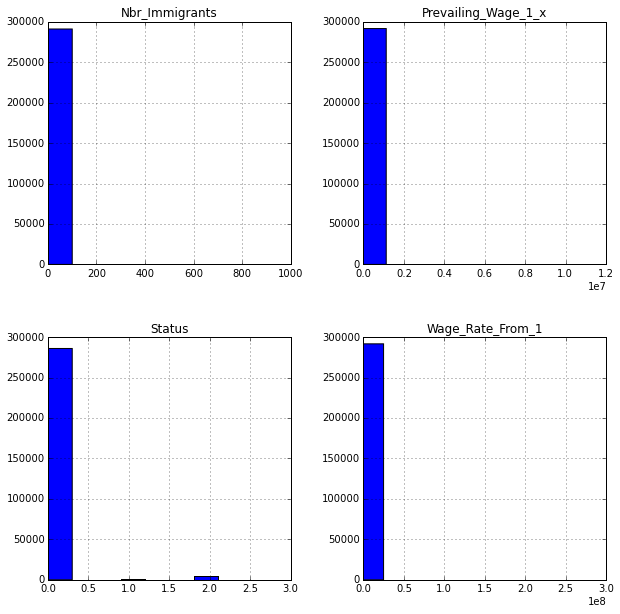

In [58]:
df4.hist(figsize=(10,10))

In [59]:
df4['Case_Status'].value_counts()


Certified    286053
Hold           5002
Denied          604
Pending         122
dtype: int64

In [60]:
df4['Employer_Name'].value_counts().sum()

291781

In [61]:
df4.columns

Index([u'Submitted_Date', u'Employer_Name', u'Program_Designation', u'State',
       u'Zip_Code', u'Nbr_Immigrants', u'Job_Title', u'Occupation_Code',
       u'Case_Status', u'Wage_Rate_From_1', u'Wage_Rate_Per_1', u'Part_Time_1',
       u'Work_City_1', u'Work_State_1', u'Prevailing_Wage_1_x',
       u'Prevailing_Wage_Source_1', u'Year_Source_Published_1',
       u'Other_Wage_Source_1', u'Withdrawn', u'Status'],
      dtype='object')

In [62]:
df5= df4[df4['Status'] ==0]
#because mostly everyone is accepted into the program let's see if we can 
#find any kind of patterns what kind of people are consuming the most Visa's

In [63]:
df5

,Submitted_Date,Employer_Name,Program_Designation,State,Zip_Code,Nbr_Immigrants,Job_Title,Occupation_Code,Case_Status,Wage_Rate_From_1,Wage_Rate_Per_1,Part_Time_1,Work_City_1,Work_State_1,Prevailing_Wage_1_x,Prevailing_Wage_Source_1,Year_Source_Published_1,Other_Wage_Source_1,Withdrawn,Status
0,12/7/2006 11:05:42,"Keynote Systems, Inc.",R,CA,94404,1.000,Software Engineer,30,Certified,100803.120,Year,N,San Mateo,CA,94474.000,O,2006,OES,N,0
1,12/13/2006 11:35:04,Wal-Mart Associates Inc.,R,AR,72716-0690,1.000,Graduate Pharmacist Intern,74,Certified,53820.000,Year,N,Red Wing,AR,25646.000,O,2006,OES Wage Data Survey,N,0
2,12/7/2006 11:05:52,"Global Consulting Group, Inc",R,MA,02375,1.000,Computer Programmer,30,Certified,28.710,Hour,N,Bellevue,MA,28.710,O,2006,OES data,N,0
3,12/7/2006 16:14:19,Sprint Nextel Corporation,R,VA,20191,1.000,RF (Radio Frequency) Engineer,3,Certified,55000.000,Year,N,Rosemont,VA,48818.000,O,2006,OES Wage Determination,N,0
5,12/7/2006 11:09:52,"Amzur Technologies, Inc.",R,FL,33602,1.000,Computer Systems Programmer Analyst,30,Certified,45000.000,Year,N,Tampa,FL,43098.000,O,2006,OES,N,0
6,12/7/2006 11:09:58,Mayo Clinic - Rochester,R,MN,55905,1.000,RESEARCH TECHNOLOGIST,78,Certified,18.060,Hour,N,ROCHESTER,MN,15.990,O,2006,OES,N,0
7,12/7/2006 11:11:12,"ONEOK Services, Inc.",R,OK,74103,1.000,IT Specialist (Development/Programmer Analyst),30,Certified,74400.000,Year,N,Tulsa,OK,45323.000,O,2006,OES/SOC Wages,N,0
8,12/8/2006 11:12:15,"PayPal, Inc.",R,CA,95131,1.000,Staff Database Engineer,39,Certified,115000.000,Year,N,San Jose,CA,93787.200,O,2005,National Compensation Survey,N,0
9,12/7/2006 11:11:31,University of Illinois at Chicago,R,IL,60607-7164,1.000,Postdoctoral Research Associate,90,Certified,39600.000,Year,N,Chicago,IL,32365.000,S,NaN,NaN,N,0
10,12/7/2006 11:11:32,"NICUSA, Inc.",R,KS,66061,1.000,Software Developer,30,Certified,38500.000,Year,N,Topeka,KS,32594.000,O,2006,Online Wage Library,N,0


In [64]:
formula = 'C(State)  +  Wage_Rate_From_1 + Prevailing_Wage_1_x + Status + Nbr_Immigrants'

In [65]:
df6 = dmatrix('C(State)  +  Wage_Rate_From_1 + Prevailing_Wage_1_x + C(Occupation_Code) + Nbr_Immigrants', df5, return_type = 'dataframe')

In [66]:
df6.head()

,Intercept,C(State)[T.AL],C(State)[T.AR],C(State)[T.AS],C(State)[T.AZ],C(State)[T.CA],C(State)[T.CO],C(State)[T.CT],C(State)[T.DC],C(State)[T.DE],...,C(Occupation_Code)[T.912],C(Occupation_Code)[T.914],C(Occupation_Code)[T.924],C(Occupation_Code)[T.962],C(Occupation_Code)[T.976],C(Occupation_Code)[T.979],C(Occupation_Code)[T.989],Wage_Rate_From_1,Prevailing_Wage_1_x,Nbr_Immigrants
0,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,100803.120,94474.000,1.000
1,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,53820.000,25646.000,1.000
2,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,28.710,28.710,1.000
3,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,55000.000,48818.000,1.000
5,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,45000.000,43098.000,1.000


In [67]:
scale = StandardScaler()

In [68]:
X_scale = scale.fit(df6).transform(df6)

In [69]:
km = KMeans(n_clusters=10, n_init=20)
km.fit(X_scale)
#let's segment the group into 10 different clusters

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=20,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [70]:
print km.inertia_

89910542.2074


In [71]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = {str(x): scale.inverse_transform(km.cluster_centers_[x]) for x in range(0,10)}
pd.DataFrame(columns, index=df6.columns)

,0,1,2,3,4,5,6,7,8,9
Intercept,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
C(State)[T.AL],-0.000,0.002,0.034,0.009,0.000,0.005,-0.000,0.000,0.000,-0.000
C(State)[T.AR],0.000,0.002,-0.000,0.001,0.000,0.004,0.000,0.000,0.000,0.000
C(State)[T.AS],0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
C(State)[T.AZ],-0.000,0.007,-0.000,0.011,0.000,0.013,0.000,0.000,0.000,0.000
C(State)[T.CA],-0.000,0.155,0.379,0.200,0.000,0.202,0.000,0.000,0.000,0.001
C(State)[T.CO],-0.000,0.007,0.000,0.006,0.000,0.010,0.000,0.000,0.000,-0.000
C(State)[T.CT],-0.000,0.013,0.138,0.016,0.000,0.017,0.000,0.000,0.000,0.000
C(State)[T.DC],0.000,0.002,0.000,0.010,0.000,0.010,0.000,0.000,0.000,0.000
C(State)[T.DE],0.000,0.014,0.000,0.004,0.000,0.004,0.000,0.000,0.000,0.000


In [72]:
df6['segments'] = km.labels_

In [73]:
df6.head()

,Intercept,C(State)[T.AL],C(State)[T.AR],C(State)[T.AS],C(State)[T.AZ],C(State)[T.CA],C(State)[T.CO],C(State)[T.CT],C(State)[T.DC],C(State)[T.DE],...,C(Occupation_Code)[T.914],C(Occupation_Code)[T.924],C(Occupation_Code)[T.962],C(Occupation_Code)[T.976],C(Occupation_Code)[T.979],C(Occupation_Code)[T.989],Wage_Rate_From_1,Prevailing_Wage_1_x,Nbr_Immigrants,segments
0,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,100803.120,94474.000,1.000,1
1,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,53820.000,25646.000,1.000,5
2,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,28.710,28.710,1.000,9
3,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,55000.000,48818.000,1.000,5
5,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,45000.000,43098.000,1.000,1


In [74]:
df6.segments.value_counts()
# we probably should make K smaller let's do 6

5    137679
1    118295
9     13339
0     11386
3      5214
2        29
6         6
7         3
8         1
4         1
dtype: int64

In [75]:
df7=df6.drop(['segments'], 1)

In [76]:
kmv2 = KMeans(n_clusters=6, n_init=10)
kmv2.fit(X_scale)
#let's segment the group into 6 different clusters this time changing the parameters

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [77]:
print kmv2.inertia_

91148707.1551


In [78]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = {str(x): scale.inverse_transform(kmv2.cluster_centers_[x]) for x in range(0,6)}
pd.DataFrame(columns, index=df7.columns)

,0,1,2,3,4,5
Intercept,1.000,1.000,1.000,1.000,1.000,1.000
C(State)[T.AL],0.001,0.004,0.002,0.000,0.000,0.000
C(State)[T.AR],0.000,0.004,0.009,0.000,0.000,0.000
C(State)[T.AS],0.000,0.000,0.000,0.000,0.000,0.000
C(State)[T.AZ],0.002,0.011,0.020,0.000,0.000,0.000
C(State)[T.CA],0.891,-0.000,0.141,0.000,0.000,0.000
C(State)[T.CO],0.002,0.009,0.013,0.000,0.000,0.000
C(State)[T.CT],0.002,0.017,0.014,0.000,0.000,0.000
C(State)[T.DC],0.000,0.007,0.010,0.000,0.000,-0.000
C(State)[T.DE],0.000,0.010,0.001,0.000,0.000,0.000


In [79]:
df7['segments'] =kmv2.labels_

In [80]:
df7['segments'].value_counts()
# still seeing a big gap in the data let's try 4 clusters

1    228560
0     52597
2      2414
5      2380
4         1
3         1
dtype: int64

In [81]:
df7= df7.drop(['segments'],1)

In [82]:
df8= df7

In [83]:
kmv3 = KMeans(n_clusters=4, n_init=30)
kmv3.fit(X_scale)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=30,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [84]:
print kmv3.inertia_

91721379.4433


In [85]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = {str(x): scale.inverse_transform(kmv3.cluster_centers_[x]) for x in range(0,4)}
pd.DataFrame(columns, index=df8.columns)

,0,1,2,3
Intercept,1.000,1.000,1.000,1.000
C(State)[T.AL],0.004,0.000,0.000,0.000
C(State)[T.AR],0.003,0.000,-0.000,-0.000
C(State)[T.AS],0.000,0.000,0.000,-0.000
C(State)[T.AZ],0.000,0.000,1.000,0.000
C(State)[T.CA],0.186,0.002,0.000,0.000
C(State)[T.CO],0.009,0.000,0.000,-0.000
C(State)[T.CT],0.016,0.000,0.000,0.000
C(State)[T.DC],0.007,-0.000,-0.000,0.000
C(State)[T.DE],0.009,0.000,0.000,0.000


In [86]:
df8['segments'] =kmv3.labels_

In [87]:
df8['segments'].value_counts()

0    253933
3     27025
2      2604
1      2391
dtype: int64

In [88]:
df8[df8['segments']==0].sample(5)

,Intercept,C(State)[T.AL],C(State)[T.AR],C(State)[T.AS],C(State)[T.AZ],C(State)[T.CA],C(State)[T.CO],C(State)[T.CT],C(State)[T.DC],C(State)[T.DE],...,C(Occupation_Code)[T.914],C(Occupation_Code)[T.924],C(Occupation_Code)[T.962],C(Occupation_Code)[T.976],C(Occupation_Code)[T.979],C(Occupation_Code)[T.989],Wage_Rate_From_1,Prevailing_Wage_1_x,Nbr_Immigrants,segments
1839,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,54600.000,52834.500,1.000,0
286431,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,33821.000,33821.000,1.000,0
141846,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,87000.000,61984.000,1.000,0
195534,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,120000.000,100984.000,1.000,0
251428,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,63000.000,62400.000,1.000,0


hmm looks like our cluster is broken out into two segments lets check to see if the company affects the segmentation. Also, let's remove the occupation code and replace it with the Employer Name

In [90]:
df5['Employer_Name'].value_counts()

Microsoft Corporation                                 3142
SATYAM COMPUTER SERVICES LTD                          2132
XCELTECH, INC                                         1838
INFOSYS TECHNOLOGIES LIMITED                          1407
IBM Corporation                                       1007
FUJITSU CONSULTING INC.                                995
Satyam Computer Services, Ltd.                         967
Patni computer systems inc.                            890
Marlabs, Inc                                           849
Ernst & Young LLP                                      848
Patni Computer Systems, Inc.                           783
Deloitte Consulting LLP                                768
GlobalCynex, Inc.                                      741
Qualcomm Inc                                           673
LARSEN & TOUBRO INFOTECH LIMITED                       671
Enterprise Business Solutions                          656
Intel Corporation                                      6

In [91]:
df5['Employer_Name'] = df5['Employer_Name'].str.lower()

/Users/ldeguzman/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [92]:
df5['Employer_Name'].head()

0           keynote systems, inc.
1        wal-mart associates inc.
2    global consulting group, inc
3       sprint nextel corporation
5        amzur technologies, inc.
Name: Employer_Name, dtype: object

In [93]:
df5['Employer_Name'].describe()
# that's a lot of different Employer's let's see if it's better to cut by job title

count                    286053
unique                    67701
top       microsoft corporation
freq                       3159
Name: Employer_Name, dtype: object

In [94]:
df5['Job_Title'].unique()
#hmm maybe if we group these jobs into categories this might just work

array(['Software Engineer', 'Graduate Pharmacist Intern',
       'Computer Programmer', ..., 'Multimedia Art Director',
       'Networks Engineer',
       'SeniorScienceAdvisor/PhysicalScientist, All Other'], dtype=object)

In [95]:
df5['Job_Title'].describe()

count                 286053
unique                 50979
top       Programmer Analyst
freq                   25786
Name: Job_Title, dtype: object

In [96]:
df5.Job_Title = df5.Job_Title.str.lower()

/Users/ldeguzman/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [97]:
df5.head()

,Submitted_Date,Employer_Name,Program_Designation,State,Zip_Code,Nbr_Immigrants,Job_Title,Occupation_Code,Case_Status,Wage_Rate_From_1,Wage_Rate_Per_1,Part_Time_1,Work_City_1,Work_State_1,Prevailing_Wage_1_x,Prevailing_Wage_Source_1,Year_Source_Published_1,Other_Wage_Source_1,Withdrawn,Status
0,12/7/2006 11:05:42,"keynote systems, inc.",R,CA,94404,1.000,software engineer,30,Certified,100803.120,Year,N,San Mateo,CA,94474.000,O,2006,OES,N,0
1,12/13/2006 11:35:04,wal-mart associates inc.,R,AR,72716-0690,1.000,graduate pharmacist intern,74,Certified,53820.000,Year,N,Red Wing,AR,25646.000,O,2006,OES Wage Data Survey,N,0
2,12/7/2006 11:05:52,"global consulting group, inc",R,MA,02375,1.000,computer programmer,30,Certified,28.710,Hour,N,Bellevue,MA,28.710,O,2006,OES data,N,0
3,12/7/2006 16:14:19,sprint nextel corporation,R,VA,20191,1.000,rf (radio frequency) engineer,3,Certified,55000.000,Year,N,Rosemont,VA,48818.000,O,2006,OES Wage Determination,N,0
5,12/7/2006 11:09:52,"amzur technologies, inc.",R,FL,33602,1.000,computer systems programmer analyst,30,Certified,45000.000,Year,N,Tampa,FL,43098.000,O,2006,OES,N,0


In [98]:
#Let's clean up the Employer Name Column

In [99]:
df5.Employer_Name= df5.Employer_Name = [x.replace('-', ' ') for x in df5.Employer_Name]

In [100]:
df5.Employer_Name= df5.Employer_Name = [x.replace(', inc.', '') for x in df5.Employer_Name]

In [101]:
df5.Employer_Name= df5.Employer_Name = [x.replace(', inc', '') for x in df5.Employer_Name]

In [102]:
df5.Employer_Name= df5.Employer_Name = [x.replace('inc.', '') for x in df5.Employer_Name]

In [103]:
df5.Employer_Name= df5.Employer_Name = [x.replace('_', ' ') for x in df5.Employer_Name]

In [104]:
df5.Employer_Name.head()

0              keynote systems
1         wal mart associates 
2      global consulting group
3    sprint nextel corporation
5           amzur technologies
Name: Employer_Name, dtype: object

In [105]:
df5.Employer_Name.describe()

count                    286053
unique                    66418
top       microsoft corporation
freq                       3159
Name: Employer_Name, dtype: object

In [106]:
dfe= df5


In [134]:
dfe.State.describe()

count     286053
unique        59
top           CA
freq       47229
Name: State, dtype: object

In [141]:
dfe.State = dfe.State.str.lower()

In [142]:
NORTHEAST=['ct', 'me', 'ma', 'nh', 'ri', 'vt', 'nj', 'ny', 'pa']
MIDWEST=['il', 'in', 'mi', 'oh', 'wi', 'ia', 'ks', 'mo', 'ne', 'nd', 'sd']
SOUTH=['de', 'fl', 'ga', 'md', 'nc', 'sc', 'va', 'dc', 'wv', 'al', 'ky', 'ms', 'tn', 'ar', 'la', 'ok', 'tx']
WEST=['az', 'co', 'id', 'mt', 'nv', 'nm', 'ut', 'wy', 'ak', 'ca', 'hi', 'or', 'wa']

def regions(x): 
    if x in NORTHEAST:
        return 'northeast'
    elif x in MIDWEST:
        return 'midwest'
    elif x in SOUTH:
        return 'south'
    elif x in WEST:
        return 'west'
    else:
        return 'territory'

dfe['region_group'] = dfe.State.apply(regions)

/Users/ldeguzman/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [143]:
dfe.head()

,Submitted_Date,Employer_Name,Program_Designation,State,Zip_Code,Nbr_Immigrants,Job_Title,Occupation_Code,Case_Status,Wage_Rate_From_1,...,Work_City_1,Work_State_1,Prevailing_Wage_1_x,Prevailing_Wage_Source_1,Year_Source_Published_1,Other_Wage_Source_1,Withdrawn,Status,job_group,region_group
0,12/7/2006 11:05:42,keynote systems,R,ca,94404,1.000,software engineer,30,Certified,100803.120,...,San Mateo,CA,94474.000,O,2006,OES,N,0,stem_job,west
1,12/13/2006 11:35:04,wal mart associates,R,ar,72716-0690,1.000,graduate pharmacist intern,74,Certified,53820.000,...,Red Wing,AR,25646.000,O,2006,OES Wage Data Survey,N,0,other,south
2,12/7/2006 11:05:52,global consulting group,R,ma,02375,1.000,computer programmer,30,Certified,28.710,...,Bellevue,MA,28.710,O,2006,OES data,N,0,stem_job,northeast
3,12/7/2006 16:14:19,sprint nextel corporation,R,va,20191,1.000,rf (radio frequency) engineer,3,Certified,55000.000,...,Rosemont,VA,48818.000,O,2006,OES Wage Determination,N,0,stem_job,south
5,12/7/2006 11:09:52,amzur technologies,R,fl,33602,1.000,computer systems programmer analyst,30,Certified,45000.000,...,Tampa,FL,43098.000,O,2006,OES,N,0,stem_job,south


northeast    96617
south        81313
west         62815
midwest      42493
territory     2815
dtype: int64

In [107]:
dfe.Job_Title

0                                         software engineer
1                                graduate pharmacist intern
2                                       computer programmer
3                             rf (radio frequency) engineer
5                      computer systems programmer  analyst
6                                     research technologist
7            it specialist (development/programmer analyst)
8                                   staff database engineer
9                           postdoctoral research associate
10                                       software developer
11                              senior technical translator
12                                      computer programmer
13                                      postdoctoral fellow
14                    engineer, software (systems software)
15                                  applications programmer
16                                 chief operations manager
17                                      

In [390]:
STEM= ['digital', 'materials', 'statistician', 'geoscientist', 'it', 'product manager','biologist','chemist', 'data', 'consultant','business', 'programmer', 'engineer', 'computer', 'systems', 'system', 'software', 'network', 'networks' , 'developer', 'developers', 'analyst', 'process', 'scientist', 'technology', 'physicist', 'technical', 'java', 'rails', 'python', 'engineering', 'online', 'unix', 'database', 'scientific' , 'embryologist', 'estimator' , 'mechanical', 'electrical', 'mathematician', 'computational']
FINANCE = [ 'sales', 'strategic', 'analsyt', 'economist', 'audit', 'loan', 'loans', 'auditor', 'manager', 'broker', 'advisor', 'financial', 'consultant', 'consulting', 'consult', 'marketing', 'market', 'marketer', 'investor', 'investing', 'banker', 'banking', 'actuary', 'accountant', 'income', 'account', 'controller', 'finance', 'financing', 'financial' 'trade', 'judge', 'defense', 'trader', 'trading', 'economics', 'ecnomist', 'executive', 'billing', 'insurance', 'tax', 'strategy' , 'risk', 'corporate', 'fund', 'accounting', 'investment', 'bank', 'banks', 'advertising', 'advertisement', 'equity', 'mergers', 'acquisition']
LEGAL= ['affairs', 'case', 'patent', 'paralegal',  'counsel','legal', 'law', 'lawyer', 'attorney', 'litigator', 'litigation', 'clerk', 'judge', 'defense' ]
EDUCATION= ['lecturer', 'faculty', 'school', 'teaching', 'educator', 'vet', 'veterinarian', 'principal','teacher', 'professer', 'professor', 'post-doctorate', 'attorney', 'fellow', 'research', 'adjunct' , 'instructor', 'scholar', 'research', 'researcher', 'student', 'esl', 'coach' ]
MEDICAL = ['gynecologist', 'rehab', 'resident', 'neurologist', 'surgical', 'therapist','doctor', 'medical', 'medic', 'nurse', 'health', 'therapy', 'psychology', 'clinical', 'clinic', 'physician', 'dental', 'dentist', 'psych', 'pharmacist', 'pharmacy', 'surgeon', 'surgery', 'paramedic', 'medicine', 'anesthesiologist', 'residential', 'animate', 'animator', 'animation']
CREATIVE = [ 'music', 'theater', 'theatre', 'language', 'acupuncturist', 'publisher', 'drafter', 'writer', 'creative' , 'art', 'architect', 'architechture', 'design', 'designer', 'fashion', 'graphic', 'graphics', 'artist', 'actor', 'event', 'social', 'editor', 'editorial', 'interpreter', 'translator', 'curator', 'museum', 'media' ]
EXECUTIVE = ['ceo', 'executive', 'president', 'coo' , 'vice']
def group_titles(x):
    tokens = x.split(' ')
    slash = x.split('/')
    dash = x.split('-')
    comma = x.split(',')
    for word in STEM:
        if word in tokens:
            return 'stem_job'
        elif word in slash:
            return 'stem_job'
        elif word in dash:
            return 'stem_job'
        elif word in comma:
            return 'stem_job'
    for word in FINANCE:
        if word in tokens:
            return 'finance_or_business_job'
        elif word in slash:
            return 'finance_or_business_job'
        elif word in dash:
            return 'finance_or_business_job'
        elif word in comma:
            return 'finance_or_business_job'
    for word in LEGAL:
        if word in tokens:
             return 'legal_job'
        elif word in slash:
            return 'legal_job'
        elif word in comma:
            return 'legal_job'
    for word in EDUCATION:
        if word in tokens:
            return 'education_job'
        elif word in slash:
            return 'education_job'
        elif word in comma:
            return 'education_job'
    for word in MEDICAL:
        if word in tokens:
            return 'medical_job'
        elif word in slash:
            return 'medical_job'   
        elif word in comma:
            return 'medical_job'
    for word in CREATIVE:
        if word in tokens:
            return 'creative_job'
        elif word in slash:
            return 'creative_job' 
        elif word in comma:
            return 'creative_job'
    for word in EXECUTIVE:
        if word in tokens:
            return 'executive_job'
        elif word in slash:
            return 'executive_job' 
        elif word in comma:
            return 'executive_job'
    else:
        return 'other'

dfe['job_group'] = dfe.Job_Title.apply(group_titles)
labels = ['tech','other']

/Users/ldeguzman/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [392]:
dfe['job_group'].value_counts()



stem_job                   193650
finance_or_business_job     25172
education_job               24527
other                       20396
medical_job                 11644
creative_job                 8452
legal_job                    1278
executive_job                 934
dtype: int64

In [391]:
dfe.Job_Title[(dfe.job_group) == 'other'].sample(10)
#great I think I have enough information in my categorie

237635                                          hospitalist
202706    practice services specialist - japanese client...
234821            program officer (social science research)
285030                        support engineer-connectivity
237233                                            associate
209959                                         psychiatrist
273691                         asst director personnel/mktg
86059                                senior biostatistician
267948                                    campaign director
23337           desktop publisher: chinese biblical studies
Name: Job_Title, dtype: object

In [393]:
dff = dfe

In [394]:
dff = dmatrix('C(job_group)  + C(region_group) + Wage_Rate_From_1 + Prevailing_Wage_1_x + Nbr_Immigrants', df5, return_type = 'dataframe')

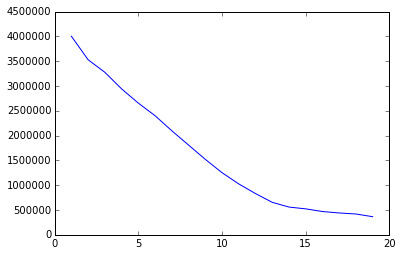

In [403]:
import matplotlib.pyplot as plt
%matplotlib inline

x = []
y = []
for n in range(1,20):
    km2 = KMeans(n_clusters=n)
    km2.fit(X_scaledff)
    x.append(n)
    y.append(km2.inertia_)
plt.plot(x, y)

In [395]:
X_scaledff = scale.fit(dff).transform(dff)

In [402]:
km = KMeans(n_clusters=13, n_init=100)
km.fit(X_scaledff)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=13, n_init=100,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [405]:
print km.inertia_

653899.520408


In [407]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = {str(x): scale.inverse_transform(km.cluster_centers_[x]) for x in range(0,13)}
pd.DataFrame(columns, index=dff.columns)

,0,1,10,11,12,2,3,4,5,6,7,8,9
Intercept,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
C(job_group)[T.education_job],-0.000,-0.000,0.175,-0.000,0.038,0.000,0.000,1.000,0.127,-0.000,-0.000,-0.000,-0.000
C(job_group)[T.executive_job],-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,1.000
C(job_group)[T.finance_or_business_job],0.000,-0.000,0.225,1.000,0.101,0.000,0.000,-0.000,0.103,-0.000,1.000,-0.000,0.000
C(job_group)[T.legal_job],0.000,0.000,0.050,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,1.000,-0.000
C(job_group)[T.medical_job],1.000,0.000,0.000,0.000,0.008,-0.000,-0.000,-0.000,0.052,-0.000,-0.000,0.000,0.000
C(job_group)[T.other],-0.000,-0.000,0.175,0.000,0.038,0.000,0.000,0.000,0.111,1.000,0.000,0.000,-0.000
C(job_group)[T.stem_job],0.000,0.960,0.325,0.000,0.808,0.967,0.941,-0.000,0.590,0.000,-0.000,0.000,-0.000
C(region_group)[T.northeast],0.399,0.690,0.375,0.000,0.528,-0.000,-0.000,0.233,0.000,0.371,0.361,0.504,0.648
C(region_group)[T.south],0.266,0.000,0.475,0.000,0.131,1.000,-0.000,0.391,-0.000,0.288,0.286,0.228,0.140


In [408]:
dff['segments'] = km.labels_

In [409]:
dff['segments'].value_counts()

1     98760
2     55386
3     45235
7     24758
4     24121
6     20034
0     11475
5      2790
8      1275
12     1144
9       934
10       40
11        1
dtype: int64

In [404]:
dff=dff.drop(['segments'], 1)

In [1]:
### total 285,953
# 1-  STEM  - 35% -Majority in northeast 
# 2 - STEM - 19% - From the South
# 3 - STEM - 15.8% - From the West
# 7 finance/business - 8.65% - northeast, south, west
# 4 - Education - 9 % -  northeast, south, west
# 6 - other -7 %  -northeast, south, west
#  0 - medical - 4 %
# 5 - STEM  .9 % - from territory 
# 8 - legal 0.4%
# 9 -Executives -  0.3%
# 10 - all over the place 
# 11 - THE EXECUTIVE